可能な限り、Mathematicaの実装に近づけて実装<br>
numpyの行列演算をうまく使えば、高速化はできるだろう．．．

# Import

In [3]:
import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D

# 座標変換

In [4]:
def w2c(tMatF, deltF, p1sF): # 世界座標系からカメラ座標系への変換
    p1scnvF = [np.dot(npl.inv(tMatF), p1sF[i] - deltF) for i in range(len(p1sF))]
    return np.stack(p1scnvF)

def c2w(tMatF, deltF, p1sF): # カメラ座標系から世界座標系への変換
    p1scnvF = [np.dot(tMatF, p1sF[[i]]) + deltF for i in range(len(p1sF))]
    return np.stack(p1scnvF)

# パラメータ

In [5]:
zvect = np.array((
    (0.15, 0., 1.),
    (-0.25, 0., 1.),
))

zvect = np.array((
    (0.25, 0., 1.),
    (-0.25, 0., 1.),
))

yvect = np.array((
    (0., 1., 0.),
    (0., 1., 0.),
))

# ローカル座標系のワールド座標系での原点座標
delt = np.array((
    (0., 0., 0.),
    (1., 0., 0.),
))

delt = np.array((
    (0.01, 0., 0.),
    (1., 0., 0.),
))

ncamera = len(zvect) # カメラ台数

# 変換行列

In [6]:
# initialize
xvecte, yvecte, zvecte = [np.zeros((ncamera,3)) for i in range(3)]
tM = np.zeros((ncamera,3,3))

for ncm in range(ncamera):
    zvecte[ncm] = zvect[ncm] / npl.norm(zvect[ncm]) # normalize
    yvecte[ncm] = yvect[ncm] / npl.norm(yvect[ncm]) # normalize
    
    if ncm==0:
        xvect = np.array([0., 0., -1])
    elif ncm==1:
        xvect = np.array([0., 0., 1])
    
    xvect[0] = np.roots([zvect[ncm][0], np.dot(xvect[1:], zvect[ncm][1:])]) # ≒ Solve # 外積を使えば...?
    xvecte[ncm] = xvect / npl.norm(xvect) # normalize
    print("xvect:", xvect)
    print("xvecte:", xvecte[ncm])
    
    for i in range(3):
        tM[ncm] = np.transpose(np.stack([xvecte[ncm], yvecte[ncm], zvecte[ncm]]))
    print()
print("tM:\n",tM)

# print("\ntMが直行行列であることを確認")
# print("\n逆行列:\n",npl.inv(tM))
# print("\n転置行列:\n",np.transpose(tM, (0,2,1)))

xvect: [ 4.  0. -1.]
xvecte: [ 0.9701425   0.         -0.24253563]

xvect: [4. 0. 1.]
xvecte: [0.9701425  0.         0.24253563]

tM:
 [[[ 0.9701425   0.          0.24253563]
  [ 0.          1.          0.        ]
  [-0.24253563  0.          0.9701425 ]]

 [[ 0.9701425   0.         -0.24253563]
  [ 0.          1.          0.        ]
  [ 0.24253563  0.          0.9701425 ]]]


# Visualization

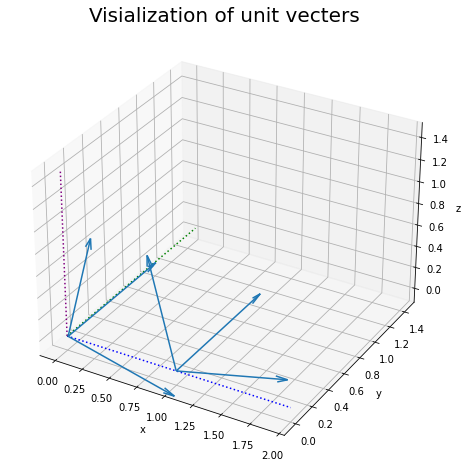

In [7]:
%matplotlib inline
# %matplotlib notebook
fig = plt.figure(figsize=(8, 8)) # 図の設定
ax = fig.add_subplot(projection='3d') # 3Dプロットの設定

for ncm in range(ncamera):
    for vecte in [xvecte, yvecte, zvecte]:
        start = delt[ncm]
        end = vecte[ncm]
        ax.quiver(*start, *end, arrow_length_ratio=0.1) # 矢印プロット

plt.plot([0, 2],[0, 0], [0, 0],
         color='blue', linestyle=':') # x軸
plt.plot([0, 0],[0, 1.5], [0, 0],
         color='green', linestyle=':') # y軸
plt.plot([0, 0],[0, 0], [0, 1.5],
         color='purple', linestyle=':') # z軸

ax.set_xlabel('x') # x軸ラベル
ax.set_ylabel('y') # y軸ラベル
ax.set_zlabel('z') # z軸ラベル
ax.set_title('Visialization of unit vecters', fontsize=20) # タイトル
# ax.legend() # 凡例
ax.set_xlim(-0.1, 2) # x軸の表示範囲
ax.set_ylim(-0.1, 1.5) # y軸の表示範囲
ax.set_zlim(-0.1, 1.5) # z軸の表示範囲
plt.show()

In [84]:
np.append(np.expand_dims(tgpos[0,0],0), np.zeros((1,3)),0)

array([[-0.5, -0.5,  2.6],
       [ 0. ,  0. ,  0. ]])

# 

In [67]:
# ターゲットのイメージを作る

tgposzFront = 3.5 - 0.9 # 前面のz座標 [m]
tgposzRear = 4.0 - 0.9 # 後面のz座標 [m]

def tgposxy(xs,ys):
    np.concatenate([np.array([[y,x] for y in np.linspace(-0.5, 0.5, 5)]) for x in np.linspace(-0.5, 0.5, 5)])

tgposxy = np.concatenate([np.array([[x,y] for y in [0.0, 1.0, 0.05]]) for x in [0.5, 1.5, 0.05]])
tgposxy = np.concatenate([np.array([[x,y] for y in [0.0, 1.0, 0.1]]) for x in [0.5, 1.5, 0.05]]) # この時に誤差が小さい
tgposxy = np.concatenate([np.array([[x,y] for y in [-1.0, 1.0, 0.5]]) for x in [-1.0, 1.5, 0.5]])
tgposxy = np.concatenate([np.array([[x,y] for y in [-0.5, 0.5, 0.2]]) for x in [0.25, 0.8, 0.1]]) # z=2.6~4.9 意外と誤差が小さい
tgposxy = np.concatenate([np.array([[x,y] for y in [-0.5, 0.5, 0.25]]) for x in [0.25, 1.25, 0.25]]) # この時に誤差が小さい
tgposxy = np.concatenate([np.array([[y,x] for y in np.linspace(-0.5, 0.5, 5)]) for x in np.linspace(-0.5, 0.5, 5)])

tgpos = np.stack([[tgposxy.T[0], tgposxy.T[1], np.repeat(tgpz, len(tgposxy))] for tgpz in [tgposzFront, tgposzRear]]).transpose(0,2,1) # 個数は同じにすること
nplain = len(tgpos) # 平面数

foculL = 0.1 # カメラ1の焦点距離
rez = (4000, 3000) # 画素数
fov = np.radians([60, 45]) # 画角
pixelRez = (2*foculL*np.tan(fov/2))/rez # 画素分解能 スクリーン面での

print("pixelRez = ", pixelRez)
print("Screen[m] ", (2*foculL*np.tan(fov/2)))

# initialize
tgCxy = np.zeros((ncamera, nplain, len(tgpos[0]), 2))
tgCuv = np.zeros((ncamera, nplain, len(tgpos[0]), 2))
dltp, dltp2 = [np.zeros((ncamera,11)) for i in range(2)]
gg = [None for i in range(ncamera)]

for ncm in range(ncamera):
    # npはnumpyで使われていたため、変数名をnpsに変更
    for nps in range(nplain): # 2平面なので
        # カメラ座標系へ
        cnvw2c = w2c(tM[ncm], delt[ncm], tgpos[nps])
        
        # カメライメージ
        for j in range(len(cnvw2c)):
            k = (foculL - 0) / (cnvw2c[j, 2] - 0)
            tgCxy[ncm,nps,j] = cnvw2c[j,:2] * k # (x,y)
            tgCuv[ncm,nps,j] = np.round(tgCxy[ncm,nps,j]/pixelRez) # (u,v)
            
        if ncm==1 or ncm==0:
            fig, ax = plt.subplots()
            ax.scatter(*tgCuv[ncm, 0].T)
            ax.scatter(*tgCuv[ncm, 1].T)
            ax.set_xlim(-rez[0]/2, rez[0]/2)
            ax.set_ylim(-rez[1]/2, rez[1]/2)
            gg[ncm] = (fig, ax)
            plt.close()

    # 可視化パートはよくわからなかったので、いったん保留する
    
    # DLT 11パラメータを求める
    tg = np.concatenate(tgpos) # flattenにレベルを指定できないため、concatenateかreshapeで対応
#     print(tg)
    ntgp = len(tg)
    uv = np.concatenate(tgCuv[ncm])
    aMat = np.zeros((ntgp*2,11))
    bMat = np.zeros((ntgp*2,))
    
    for n in range(ntgp):
        x, y, z, u, v = tg[n,0], tg[n,1], tg[n,2], uv[n,0], uv[n,1]
        aMat[2*n]   = [x, y, z, 1, 0, 0, 0, 0, -u*x, -u*y, -u*z]
        aMat[2*n+1] = [0, 0, 0, 0, x, y, z, 1, -v*x, -v*y, -v*z]
        bMat[2*n]   = u
        bMat[2*n+1] = v
        
    print("\nDimensions:\naMat.shape\n", aMat.shape, "\nbMat.shape\n", bMat.shape)
#     np.set_printoptions(suppress=True)
#     print("\naMat:\n",aMat)
#     print("\nbMat:\n",bMat)
    dltp[ncm] = np.dot(npl.pinv(aMat), bMat)
    dltp2[ncm] = np.dot(npl.inv(np.dot(aMat.T, aMat)), np.dot(aMat.T, bMat))

    uvmemo = uv

print("\ndltp:\n",dltp)
print("\ndltp2:\n", dltp2)
print("\nDifference:\n", dltp-dltp2)
print("\nMax of Difference:\n", np.max(dltp-dltp2))

pixelRez =  [2.88675135e-05 2.76142375e-05]
Screen[m]  [0.11547005 0.08284271]

Dimensions:
aMat.shape
 (100, 11) 
bMat.shape
 (100,)

Dimensions:
aMat.shape
 (100, 11) 
bMat.shape
 (100,)

dltp:
 [[ 3.29671654e+04 -2.49088250e-11 -7.90364131e+03 -1.28139633e+03
  -4.43859853e-11  3.55235328e+04 -1.16940138e-11  5.51608828e-11
   2.37878938e+00 -2.03011219e-13  9.15291043e+00]
 [ 1.40541061e+04  6.96176033e-11  3.50368131e+03 -1.40263919e+04
  -8.47726880e-12  1.51436564e+04  1.66091377e-11 -4.98910843e-11
  -1.01223854e+00 -4.46795378e-14  4.06160387e+00]]

dltp2:
 [[ 3.29671654e+04 -1.38668696e-11 -7.90364130e+03 -1.28139634e+03
   9.69465710e-14  3.55235327e+04  3.63992625e-12 -7.33727884e-12
   2.37878937e+00  1.61005710e-14  9.15291042e+00]
 [ 1.40541061e+04  2.85846672e-13  3.50368131e+03 -1.40263919e+04
  -2.45722790e-14  1.51436564e+04  1.10542890e-12 -3.43153129e-12
  -1.01223854e+00 -1.97526358e-15  4.06160387e+00]]

Difference:
 [[ 5.34791616e-05 -1.10419554e-11 -1.92768857e

参考：
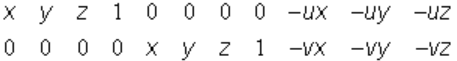

In [118]:
n=0
uv[n,0]*dltp[n,8:11]-dltp[n,0:3]

array([-3.53221669e+04,  2.25889932e-10, -1.15774001e+03])

In [119]:
# DLT 11パラメータを使った計測
# 対応点探索誤差を調べる。CPの周囲に、面状に

aMat = np.zeros((ntgp*2,11))
bMat = np.zeros((ntgp*2,))
tguv = [1, np.round(tgCuv.shape[2]/3*2)] # ■目標とするCP■ # 前面or後面 CPの番号
tguv = [1, 5] # ■目標とするCP■ # 前面or後面 CPの番号
duv = np.array([[[k1,k2] for k1 in [0, 1, 1]] for k2 in [0, 1, 1]]) # 面上の範囲 単位はpixel

dif, memotgp3D = np.array([np.zeros((duv.shape[0], duv.shape[1])) for i in range(2)])

print("tguv No. =", tguv, "\ntg=\n", tgCuv[[0,1],tguv[0], tguv[1]], "  [pixel]")
print("tgpos[tguv[0],tguv[1]] =", tgpos[tguv[0], tguv[1]])
print("tgposzFront =", tgposzFront)
print("tgposzRear =", tgposzRear)

# ggp1 = plt.subplots()
# ggp1[1].scatter(*tgCuv[0, tguv[0], tguv[1]], s=50, c='red')
# ggp2 = plt.subplots()
# ggp2[1].scatter(*tgCuv[1, tguv[0], tguv[1]], s=50, c='red')
# plt.close()

for nt2 in range(duv.shape[1]):
    for nt1 in range(duv.shape[0]):
        for n in range(ncamera):
            aMat[2*n]   = uv[n,0]*dltp[n,8:11]-dltp[n,0:3]
            aMat[2*n+1] = uv[n,0]*dltp[n,8:11]-dltp[n,5:8]
            bMat[2*n]   = dltp[n,3] - uv[n,0]
            bMat[2*n+1] = dltp[n,7] - uv[n,1]

        tgp3D = np.dot(np.dot(npl.inv(np.dot(aMat.T, aMat)),aMat.T), bMat)


tguv No. = [1, 5] 
tg=
 [[-1498.  -314.]
 [ -723.  -269.]]   [pixel]
tgpos[tguv[0],tguv[1]] = [-0.5  -0.25  3.1 ]
tgposzFront = 2.6
tgposzRear = 3.1


ValueError: could not broadcast input array from shape (3,) into shape (11,)

In [108]:
tgCuv[1, tguv[0], tguv[1]]

array([-723., -269.])

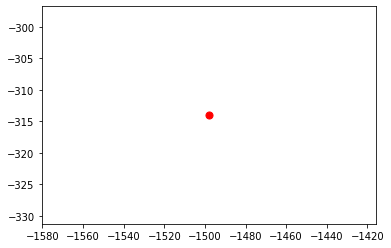

In [111]:
ggp1[0]

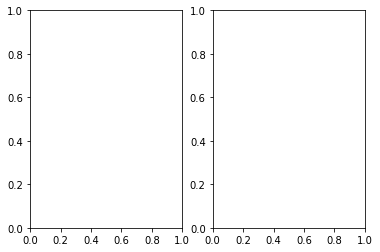

In [113]:
ggp = plt.subplots(1,2)
ggp[1][0] = ggp1[1]

In [77]:
tgCuv[[0,1]][:,:,(1,5)]

array([[[[ -865.,  -715.],
         [-1221.,  -363.]],

        [[ -809.,  -598.],
         [-1105.,  -303.]]],


       [[[ -714.,  -641.],
         [ -990.,  -314.]],

        [[ -482.,  -547.],
         [ -723.,  -269.]]]])

In [86]:
tgpos[[0,1],[1,5]]

array([[-0.25, -0.5 ,  2.6 ],
       [-0.5 , -0.25,  3.1 ]])

<IPython.core.display.Javascript object>


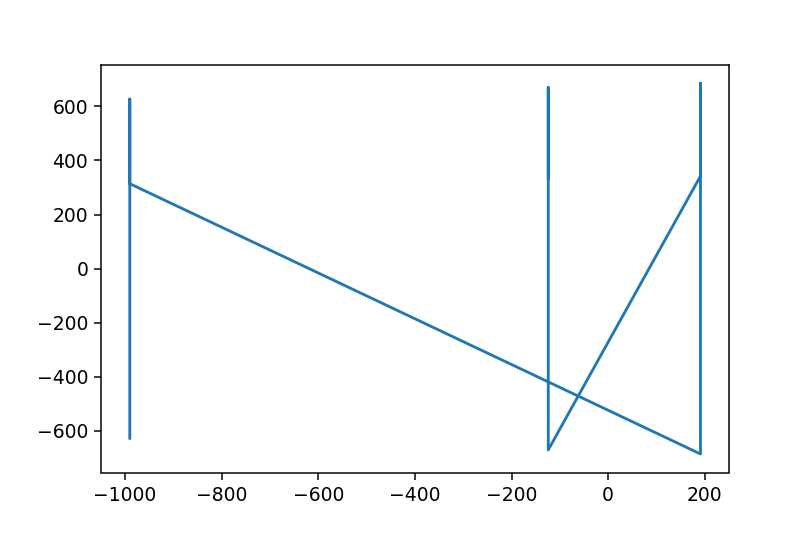

In [223]:
fig, ax = plt.subplots(1)
ax.plot(tgCuv[ncm,0].T[0], tgCuv[ncm,0].T[1])

In [226]:
np.concatenate(tgpos)

array([[-0.5 , -0.5 ,  2.6 ],
       [-0.5 ,  0.5 ,  2.6 ],
       [-0.5 ,  0.25,  2.6 ],
       [ 0.5 , -0.5 ,  2.6 ],
       [ 0.5 ,  0.5 ,  2.6 ],
       [ 0.5 ,  0.25,  2.6 ],
       [ 0.25, -0.5 ,  2.6 ],
       [ 0.25,  0.5 ,  2.6 ],
       [ 0.25,  0.25,  2.6 ],
       [-0.5 , -0.5 ,  3.1 ],
       [-0.5 ,  0.5 ,  3.1 ],
       [-0.5 ,  0.25,  3.1 ],
       [ 0.5 , -0.5 ,  3.1 ],
       [ 0.5 ,  0.5 ,  3.1 ],
       [ 0.5 ,  0.25,  3.1 ],
       [ 0.25, -0.5 ,  3.1 ],
       [ 0.25,  0.5 ,  3.1 ],
       [ 0.25,  0.25,  3.1 ]])